In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms, datasets
import cv2
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
img_size = (224,224)
batch_size = 1

In [5]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

Shape of Image is:  torch.Size([1, 3, 224, 224])
The class ID is tensor([3]) and it is cat
the mean values of unnormalised image across R,G,B is tensor([0.5163, 0.4816, 0.4765])
the std values of unnormalised image across R,G,B is tensor([0.1661, 0.1594, 0.1740])


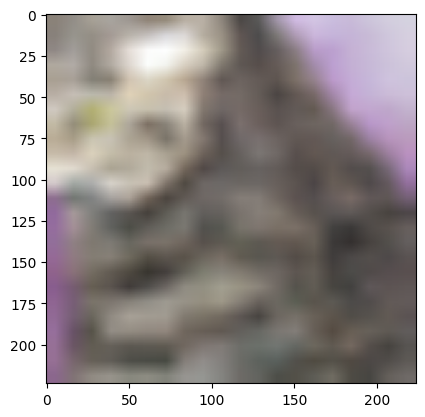

Shape of Image is:  torch.Size([1, 3, 224, 224])
The class ID is tensor([9]) and it is truck
the mean values of unnormalised image across R,G,B is tensor([0.6514, 0.6027, 0.6117])
the std values of unnormalised image across R,G,B is tensor([0.1891, 0.1680, 0.1520])


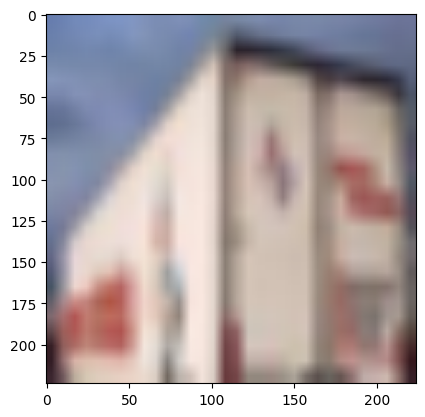

Shape of Image is:  torch.Size([1, 3, 224, 224])
The class ID is tensor([1]) and it is automobile
the mean values of unnormalised image across R,G,B is tensor([0.1517, 0.2535, 0.4333])
the std values of unnormalised image across R,G,B is tensor([0.1384, 0.1514, 0.2565])


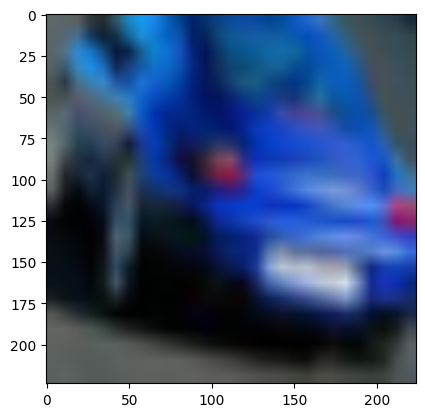

Shape of Image is:  torch.Size([1, 3, 224, 224])
The class ID is tensor([5]) and it is dog
the mean values of unnormalised image across R,G,B is tensor([0.5670, 0.5700, 0.5472])
the std values of unnormalised image across R,G,B is tensor([0.2388, 0.2393, 0.2480])


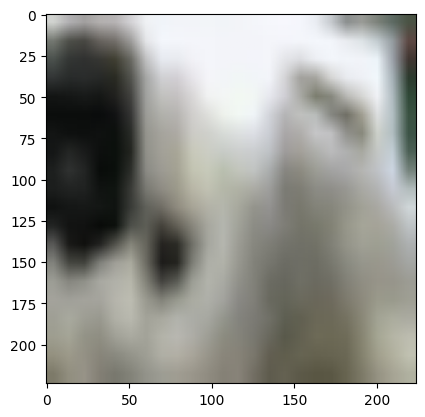

Shape of Image is:  torch.Size([1, 3, 224, 224])
The class ID is tensor([3]) and it is cat
the mean values of unnormalised image across R,G,B is tensor([0.6543, 0.6317, 0.5908])
the std values of unnormalised image across R,G,B is tensor([0.3515, 0.3471, 0.3505])


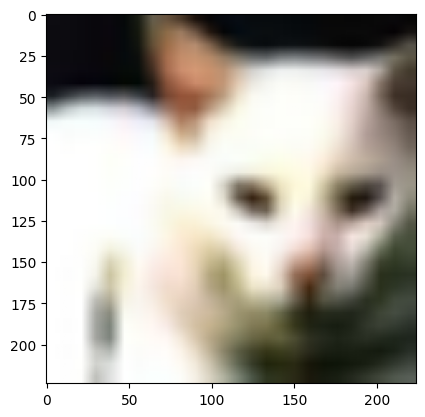

Shape of Image is:  torch.Size([1, 3, 224, 224])
The class ID is tensor([4]) and it is deer
the mean values of unnormalised image across R,G,B is tensor([0.6084, 0.6598, 0.6440])
the std values of unnormalised image across R,G,B is tensor([0.3167, 0.2669, 0.2946])


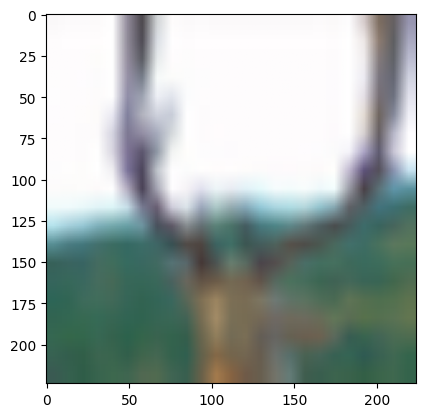

In [7]:
count = 0
for _, (image, label) in enumerate(train_loader):
    if count>5:
        break
    print("Shape of Image is: ",image.shape)
    print(f"The class ID is {label} and it is {cifar10_classes[label.item()]}")
    image_plt = image.squeeze(0).permute(1,2,0)
    print(f"the mean values of unnormalised image across R,G,B is {image_plt.mean(dim=(0,1))}")
    print(f"the std values of unnormalised image across R,G,B is {image_plt.std(dim=(0,1))}")
    plt.imshow(image_plt)
    plt.show()
    count+=1
    

### Classwise Distribution

50000it [00:29, 1685.56it/s]


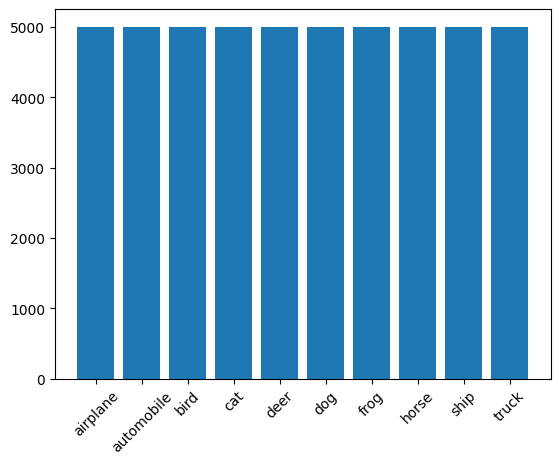

In [8]:
class_count = [0 for _ in range(10)]

for i, (image, label) in tqdm(enumerate(train_loader)):
    class_count[label.item()] += 1

plt.bar(cifar10_classes.values(), class_count)
plt.xticks(rotation=45)
plt.show()

In [10]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load('myModel.pth'))

<All keys matched successfully>

In [12]:
model.classifier[6]=nn.Identity()

In [13]:
val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
val_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=val_transform)
test_dataset, val_dataset = train_test_split(val_dataset, test_size=0.2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
features = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.append(outputs.cpu().numpy().reshape(-1))

100%|███████████████████████████████████████| 8000/8000 [01:48<00:00, 73.44it/s]


In [23]:
features = np.array(features)
features.shape

(8000, 4096)

In [26]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
reduced_features = tsne.fit_transform(features)

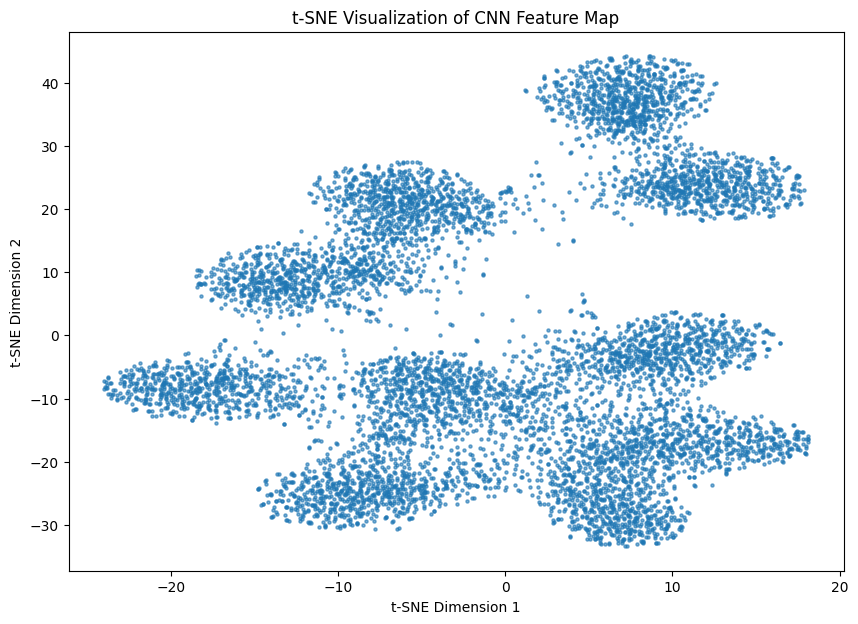

In [28]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of CNN Feature Map")
plt.show()

There is a clear distinction of the 10 classes in the T-SNE plot of the feature map